In [1]:
dataset_name = "W16_comb"
df_list = [
           "BES_Panel",
#            "BES_reduced_with_na",
#            "BESnumeric"
#            "BES_reduced",
#            "BESnumeric"
          ]

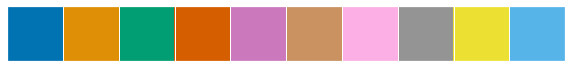

In [2]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re
sns.set()
sns.palplot(sns.color_palette("colorblind"))
from IPython.display import display, display_html, HTML
plt.rcParams["axes.grid"] = False

import Jupyter_module_loader
from utility import *
import gaussian_kde

import warnings
warnings.filterwarnings('ignore')


In [3]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
# %matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()



In [4]:
global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
# (var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

In [5]:
pan_dataset_allr_values = pd.read_csv(BES_small_data_files + "pan_dataset_allr_values"+".csv")

In [6]:
global best_weight_series
def weighted_mean(series):
    return (series*best_weight_series.loc[series.index]).sum()/(best_weight_series.loc[series.index]).sum()


In [149]:
BES_census_data = pd.read_stata( BES_small_data_files + "BES-2017-General-Election-results-file-v1.0.dta" )
print("BES_census_data", BES_census_data.shape )

BES_census_data (632, 308)


In [13]:
# BES_census_data.columns

In [14]:
# BES_census_data.dtypes.value_counts()

In [15]:
# BES_census_data.columns[BES_census_data.dtypes=='category']
# Country: category (England/Scotland/Wales)
# Region: category (gor)
# ConstituencyType: category County|Borough
# <party categories>: 'Winner17', 'Winner15', 'Winner10',
# Male|Female <party>PPCsex<15|17>
# White|BME <party>PPCrace<15|17>


In [150]:
# BES_census_data.columns[BES_census_data.dtypes=='int16']
# 'RejectedVote17', 'RejectedVote15'
# pano = constId

c11_vars = [x for x in BES_census_data.columns[BES_census_data.dtypes=='float'] if "c11" in x]
nonc11vars = [x for x in BES_census_data.columns[BES_census_data.dtypes=='float'] if "c11" not in x]

num_non_perc_vars = ['RejectedVote17', 'RejectedVote15']
num_non_perc_vars.extend(list(BES_census_data.columns[BES_census_data.dtypes=='int32']))
num_non_perc_vars.append('c11PopulationDensity')

percentage_vars = c11_vars
percentage_vars.remove('c11PopulationDensity')

percentage_vars.extend( list(BES_census_data[nonc11vars].columns[ BES_census_data[nonc11vars].max()<=100 ]) )

num_non_perc_vars.extend( list(BES_census_data[nonc11vars].columns[ BES_census_data[nonc11vars].max()>100 ]) )

id_vars = ["pano","ONSConstID","ConstituencyName"]
name_vars = [x for x in BES_census_data.columns if re.search("PPC(17|15)",x)]

In [151]:
BES_census_data[["SeatChange1517","SeatChange1015"]] = BES_census_data[["SeatChange1517","SeatChange1015"]].replace(" ",np.nan).astype('category')

categorical_vars = list( BES_census_data.columns[BES_census_data.dtypes=='category'] )
categorical_vars.extend(["SeatChange1517","SeatChange1015"])


df = pd.concat([ pd.get_dummies(BES_census_data[categorical_vars]),
                 BES_census_data[ percentage_vars+num_non_perc_vars ] ], axis=1).astype('float')

In [10]:
# categorical_vars
# percentage_vars

# # non-electoral
# # categorical_vars - Country, Region, ConstituencyType
# # percentage_vars - all the c11 stuff, maybe leave/remainHanretty
# # num_non_perc_vars ->  c11Population, c11PopulationDensity

In [152]:
non_pol_vars = [x for x in df.columns if "c11" in x]
non_pol_vars.extend([x for x in df.columns if "Country" in x])
non_pol_vars.extend([x for x in df.columns if "Region" in x])
non_pol_vars.extend([x for x in df.columns if "ConstituencyType" in x])
# non_pol_vars

In [20]:
# BES_census_data.columns[BES_census_data.dtypes=='object']
# ONSConstID: ONS area code
# ConstituencyName: ... Const name
# SeatChange1517,SeatChange1015: categorical!
# Names:
#        'ConPPC17', 'LabPPC17', 'LDPPC17', 'SNPPPC17', 'PCPPC17', 'UKIPPPC17',
#        'GreenPPC17', 'ConPPC15', 'LabPPC15', 'LDPPC15', 'SNPPPC15', 'PCPPC15',
#        'UKIPPPC15', 'GreenPPC15'

In [21]:


# all aggregate %s

# c11PassportAny ... goes up to 103%!
# c11PopulationDensity ... absolute value, not %
# BES_census_data[nonc11vars].columns[ BES_census_data[nonc11vars].max()<=100 ]
# BES_census_data[nonc11vars].columns[ BES_census_data[nonc11vars].max()>100 ]

In [153]:
## noting that Age tends to drawn into the diversity axes

non_pol_vars_minus_regions = [x for x in non_pol_vars if not re.match("Country_|Region_|ConstituencyType",x)]

In [154]:
df = df.apply(lambda x: x.fillna(x.mean()))

In [155]:
temp_df = df.copy()
df = df[non_pol_vars_minus_regions]

In [156]:
## Lets try some PCA!


Treatment = "census_PCA"

output_subfolder = BES_output_folder + Treatment + os.sep
if not os.path.exists( output_subfolder ):
    os.makedirs( output_subfolder )

In [157]:
df_cols = df.columns
df_ind = df.index

# normalise data (subtract out the mean, divide through by standard deviation)
clean_feature_set_std = StandardScaler().fit_transform(df.values )
BES_std = pd.DataFrame(      clean_feature_set_std,
                             columns = df_cols,
                             index   = df_ind      )

In [186]:
%%time
# 5 mins
## RUN (some variant of) PCA (potentially v slow!)
n_components = BES_std.shape[1]
n_components = 3
# (svd_solver='full', n_components='mle',whiten=True)
decomp = PCA(n_components = n_components,svd_solver='full')
# decomp = FastICA(algorithm='deflation', fun='exp', fun_args=None, max_iter=1000,
#     n_components=None, random_state=None, tol=0.07, w_init=None, whiten=False) # 2h 1min 4s "fast"
# decomp = SparsePCA(n_components=n_components, alpha=17,max_iter=1000,n_jobs=4,tol=1e-10, verbose=True) # 5min
#
# alpha=2 -> 1hr

# decomp = FactorAnalysis(svd_method = 'lapack',n_components = n_components) ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0] 
# ,n_components=30

X_r = decomp.fit_transform(BES_std)

BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = df_ind)

Wall time: 33 ms


In [187]:
# treatdir = BES_data_folder+Treatment
# subdir = BES_data_folder+Treatment+decomp_method
load_suff = "FactorAnalysis"
save = True # False => Load

if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
    decomp_method = str(decomp).split("(")[0] 
    subdir = output_subfolder + decomp_method
    fname = subdir+ os.sep + decomp_method
    # create dir, save decomp object, BES_decomp, BES_std    
    if not os.path.exists(subdir): os.makedirs(subdir)
    with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
    BES_decomp.to_msgpack(fname+".msgpack"     )
    BES_std.to_msgpack(   fname+"_std"+".msgpack" )
    
else: # LOAD decomp results (default is SAVE)
    decomp_method = load_suff
    subdir = output_subfolder + os.sep + decomp_method    
    fname = subdir + os.sep + decomp_method
    if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
    # load decomp object, BES_decomp, BES_std, n_components
    with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
    BES_decomp = pd.read_hdf(fname+".hdf")
    BES_std    = pd.read_hdf(fname+"_std"+".hdf")
    n_components = decomp.components_.shape[0] 

In [188]:
# display_pca_data(n_components, decomp, BES_std)

In [189]:
# SUPER USEFUL FOR FEATURE EXTRACTION/VARIABLE PREP!

if hasattr(decomp, 'noise_variance_'):
    if not isinstance(decomp.noise_variance_, float):
        NoiseVariance = pd.DataFrame( decomp.noise_variance_ , index = BES_std.columns, columns = ["noise_variance_"])
        NoiseVariance.hist( bins = int(len( NoiseVariance )/10) )
        NoiseVariance = NoiseVariance.sort_values(by="noise_variance_")
        display( NoiseVariance )
        display( NoiseVariance[ NoiseVariance["noise_variance_"]>.9 ].sort_index() )

In [190]:
def display_components(n_components, decomp, cols, BES_decomp, manifest, 
                       save_folder = False, show_first_x_comps=4,
                       show_histogram=True, flip_axes=True, max_comp=20, max_var_per_comp = 30):
    
    if hasattr(decomp, 'coef_'):
        decomp_components = decomp.coef_
    elif hasattr(decomp, 'components_'):
        decomp_components = decomp.components_
    else:
        raise ValueError('no component attribute in decomp')    

    # hardcoded at 20?    
    n_comps = min(n_components,max_comp)
    comp_labels = {}
    comp_dict = {}

    for comp_no in range(0,n_comps):

        fig, axes = plt.subplots(ncols=1+show_histogram)
        
        comp = pd.DataFrame( decomp_components[comp_no], index = cols, columns = ["components_"] )
        comp["comp_absmag"] = comp["components_"].abs()
        comp = comp.sort_values(by="comp_absmag",ascending=True)        
        
        if show_histogram:
            comp_ax = axes[0]
            
            hist_ax = axes[1]
            hist_ax.set_xlabel("abs. variable coeffs")
            hist_ax.set_title("Histogram of abs. variable coeffs")
            comp["comp_absmag"].hist( bins=30, ax=hist_ax, figsize=(10,6) )
            
        else:
            comp_ax = axes
            
        # set top abs_mag variable to label
        comp_labels[comp_no] = comp.index[-1:][0] # last label (= highest magnitude)
        # if top abs_mag variable is negative
     
        if flip_axes & (comp[-1:]["components_"].values[0] < 0):

            comp["components_"]         = -comp["components_"]
            decomp_components[comp_no]  = -decomp_components[comp_no]
            BES_decomp[comp_no]         = -BES_decomp[comp_no]

        dataset_description = manifest["Friendlier_Description"].values[0]
        title = "Comp. "+str(comp_no)+" (" + comp.index[-1:][0] + ")"
        comp_labels[comp_no] = title
        comp_ax.set_title( dataset_description + "\n" + title )
        comp_ax.set_xlabel("variable coeffs")
        xlim = (min(comp["components_"].min(),-1) , max(comp["components_"].max(),1) )
        comp["components_"].tail(max_var_per_comp).plot( kind='barh', ax=comp_ax, figsize=(10,6), xlim=xlim )
        dataset_citation = "Source: " + manifest["Citation"].values[0]

        if (save_folder != False):
            comp_ax.annotate(dataset_citation, (0,0), (0, -40),
                             xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7)            
            fname = save_folder + clean_filename(title) + ".png"
            fig.savefig( fname, bbox_inches='tight' )

        comp_dict[comp_no] = comp
        # show first x components
        if (comp_no >= min(show_first_x_comps,n_components)):
            plt.close()

        
    return (BES_decomp, comp_labels, comp_dict)

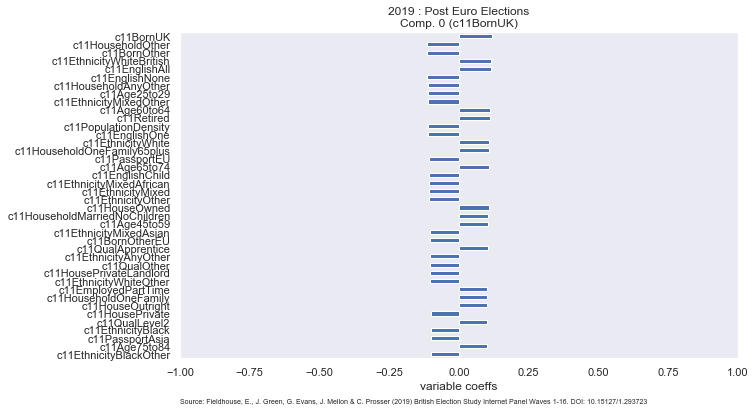

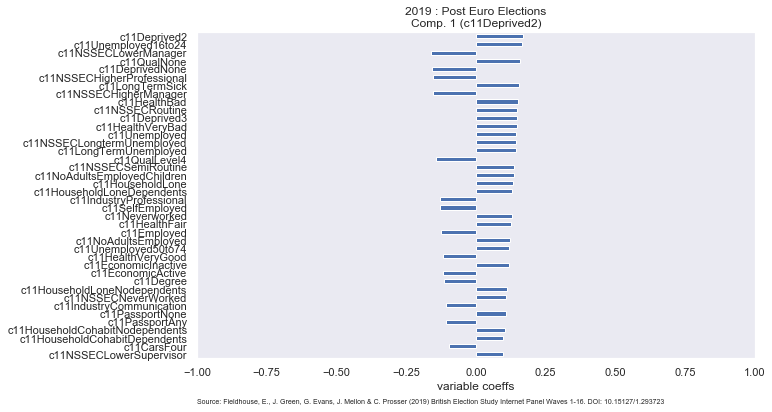

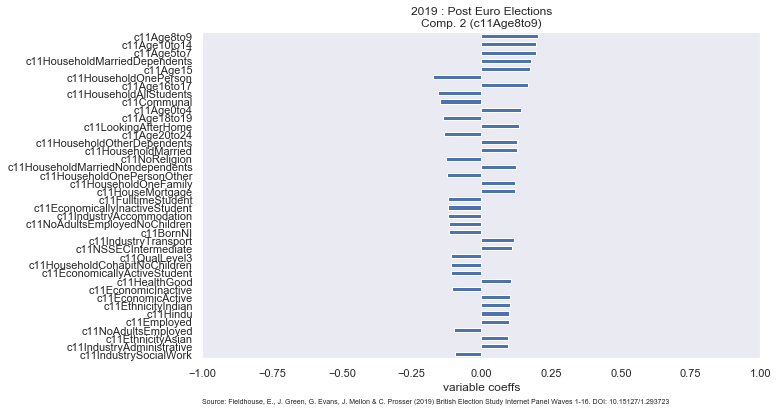

In [191]:
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          df_cols, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False, max_var_per_comp=40)

In [192]:
BES_decomp.columns = ["diversity","security","fecundity"]
# ClockFace X axis - left is high diversity, right is low diversity
# ClockFace Y axis - up is high securty, down is low security

BES_decomp["security"] = -BES_decomp["security"]

In [193]:
granularity = 201
x_axis = "diversity_flatter"
y_axis = "security_flatter"
BES_decomp[x_axis] = pd.qcut( BES_decomp["diversity"], q=granularity, labels=range(0,granularity))
BES_decomp[y_axis] = pd.qcut( BES_decomp["security"], q=granularity, labels=range(0,granularity))

In [194]:
# x_axis,y_axis = ("diversity","security")


In [195]:
search(BES_census_data,"winner")

Winner17      632
Winner15      632
Winner10      632
MRP_winner    632
dtype: int64

In [196]:
BES_census_data["Winner17"].value_counts()

Conservative               317
Labour                     262
Scottish National Party     35
Liberal Democrat            12
Plaid Cymru                  4
Speaker                      1
Green                        1
Name: Winner17, dtype: int64

In [197]:
replace_dict = {'Labour Party':"LAB", 
 'United Kingdom Independence Party (UKIP)':"UKIP",
 'Labour':"LAB",
 'Conservative Party':"CON",
 'Conservative':"CON",
 'Liberal Democrats':"LD",
 'Did not vote':"DNV",
 'Scottish National Party':"SNP",
 'Scottish National Party (SNP)':"SNP",
 'British National Party (BNP)':"BNP",
 'Green Party':"GRN","Green":"GRN",
 'Liberal Democrat':"LD",
 "Don't know":"DK",
 'Some other party':"OTH",
 'Veritas':"VER",
 'Plaid Cymru':"PC",
 'Other':"OTH",
 'Respect':"RES",
 'I would not vote':"DNV",
 'No - none':"NON",
 "Brexit Party":"BXP",
 'Change UK- The Independent Group':"CUK",
 "Leave the EU":"LEAVE",
 "Stay/remain in the EU":"REMAIN",
 "Speaker":"SPK","Speaker.":"SPK",}

party_colour_dict = {"Lab":"red","LAB":"red",
                     "Con":'blue',"CON":'blue',"UKIP":"purple","LD":"orange",
                     "Grn":'green',"GRN":'green',
                     "BrexitParty":"cyan","BXP":'cyan',
                     "TIG":"pink","BNP":"magenta",
                     "SNP":'yellow',"PC":'olive',
                     "SPK":'black',
                     "OTH":'brown'}

# ['olive', 'purple', 'orange', 'red', 'cyan',
#                       'limegreen', 'darkred', 'blue', 'chocolate',
#                       'pink', 'darkgreen', 'yellow', 'darkorange','magenta', 'mediumspringgreen', 'tomato', 'teal',
#                       'goldenrod',  'indianred']

In [198]:
# colours = 
# colours.replace(replace_dict).replace(party_colour_dict).value_counts()

In [199]:
YouGovMRP = pd.read_csv( BES_small_data_files + "YouGov_MRP_party_constituency_vote_shares.csv" )
YouGovMRP.loc[592,"constituency"] = 'Ynys Môn'
## Non-ascii characters!!!
MRP_winner = YouGovMRP.set_index("constituency").loc[BES_census_data["ConstituencyName"]][['Con', 'Lab', 'LD', 'Brexit', 'Green', 'SNP',
       'PC', 'Other']].idxmax(axis=1)

print("YouGovMRP", YouGovMRP.shape )

YouGovMRP (632, 12)


In [200]:
BES_census_data["MRP_winner"] = MRP_winner.replace(replace_dict).reset_index()[0]
parties_present = BES_census_data[["Winner10","Winner15","Winner17","MRP_winner"]].replace(replace_dict).applymap(lambda x: x.upper()).stack().value_counts().index


# MRP_winner.replace(replace_dict).reset_index()[0]
                

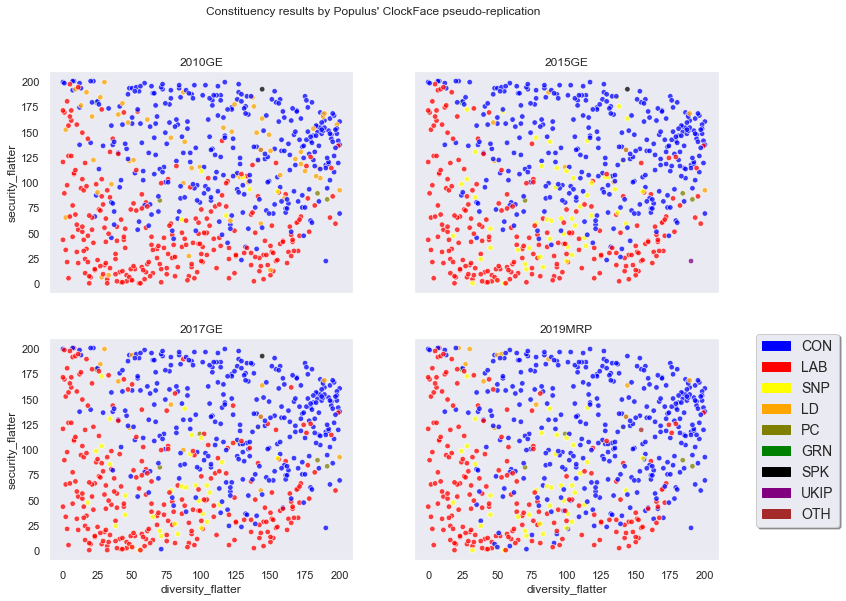

In [201]:
import matplotlib.patches as mpatches

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,9))
fig.suptitle('Constituency results by Populus\' ClockFace pseudo-replication')
sns.scatterplot(x=x_axis, y=y_axis, data=BES_decomp,
                     hue = BES_census_data["Winner10"].replace(replace_dict),
                     palette = party_colour_dict, ax=ax1, legend = False, alpha=.75, s=30)
ax1.set_title("2010GE")
sns.scatterplot(x=x_axis, y=y_axis, data=BES_decomp,
                     hue = BES_census_data["Winner15"].replace(replace_dict),
                     palette = party_colour_dict, ax=ax2, legend = False, alpha=.75, s=30)
ax2.set_title("2015GE")
sns.scatterplot(x=x_axis, y=y_axis, data=BES_decomp,
                     hue = BES_census_data["Winner17"].replace(replace_dict),
                     palette = party_colour_dict, ax=ax3, legend = False, alpha=.75, s=30)
ax3.set_title("2017GE")
sns.scatterplot(x=x_axis, y=y_axis, data=BES_decomp,
                     hue = MRP_winner.replace(replace_dict).reset_index()[0],
                     palette = party_colour_dict, ax=ax4, legend = False, alpha=.75, s=30)
ax4.set_title("2019MRP")


legend_patch_list = []
parties_present = BES_census_data[["Winner10","Winner15","Winner17","MRP_winner"]].replace(replace_dict).applymap(lambda x: x.upper()).stack().value_counts().index
for party in parties_present:
    legend_patch_list.append( mpatches.Patch(color=party_colour_dict[party], label=party) )
plt.legend(handles=legend_patch_list, bbox_to_anchor=(1.1, 1.05),
           fancybox=True, shadow=True, fontsize=14)

for ax in fig.get_axes():
    ax.label_outer()

In [70]:
( (BES_census_data["Winner17"]!="Labour") & (MRP_winner=="Lab") ).sum()
#MRP_winner

0

In [71]:
MRP_winner.value_counts()

Con      364
Lab      207
SNP       43
LD        12
PC         4
Other      1
Green      1
dtype: int64

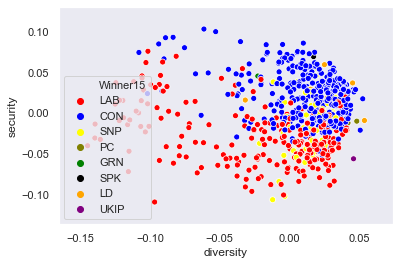

In [72]:
ax = sns.scatterplot(x="diversity", y="security", data=BES_decomp,
                     hue = BES_census_data["Winner15"].replace(replace_dict),
                     palette = party_colour_dict)

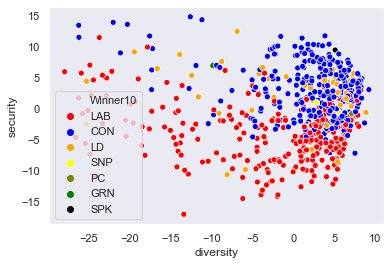

In [202]:
ax = sns.scatterplot(x="diversity", y="security", data=BES_decomp,
                     hue = BES_census_data["Winner10"].replace(replace_dict),
                     palette = party_colour_dict)

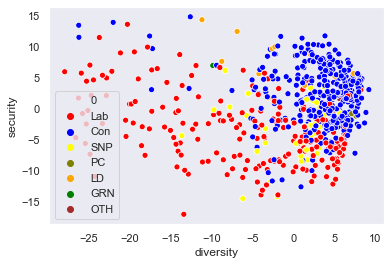

In [203]:
ax = sns.scatterplot(x="diversity", y="security", data=BES_decomp,
                     hue = MRP_winner.replace(replace_dict).reset_index()[0],
                     palette = party_colour_dict)

In [46]:
MRP_winner.replace(replace_dict).reset_index()[0]

0      Lab
1      Con
2      SNP
3      Con
4      Con
      ... 
627    Con
628    Con
629    Lab
630    Con
631    Con
Name: 0, Length: 632, dtype: object

In [54]:
fn = BES_data_folder+"parliamentary constituency data"+os.sep+"clockFace_approx.csv"
BES_decomp["ONSConstID"] = BES_census_data["ONSConstID"]
BES_decomp["ConstituencyName"] = BES_census_data["ConstituencyName"]
BES_decomp.to_csv(fn)

In [53]:
BES_census_data

,pano,ONSConstID,ConstituencyName,Country,Region,ConstituencyType,Winner17,Con17,Lab17,LD17,...,c11HealthVeryBad,c11NoAdultsEmployed,c11NoAdultsEmployedChildren,c11NoAdultsEmployedNoChildren,c11DeprivedNone,c11Deprived1,c11Deprived2,c11Deprived3,c11Deprived4,MRP_winner
0,1,W07000049,Aberavon,Wales,Wales,County,Labour,17.737766,68.119514,1.800529,...,2.691546,42.462109,6.230530,36.231580,32.230740,29.679023,27.795863,9.832336,0.462039,Lab
1,2,W07000058,Aberconwy,Wales,Wales,County,Conservative,44.594090,42.618974,2.926905,...,1.313480,40.390082,3.115130,37.274953,40.875711,34.258528,19.590967,4.761529,0.513266,Con
2,3,S14000001,Aberdeen North,Scotland,Scotland,Borough,Scottish National Party,22.692276,30.010610,4.605925,...,1.059666,31.955123,3.209807,28.745316,40.373828,33.189665,19.629204,6.051418,0.755886,SNP
3,4,S14000002,Aberdeen South,Scotland,Scotland,Borough,Conservative,42.132470,20.549300,5.866091,...,0.700666,26.960984,1.742846,25.218138,51.914644,30.473801,13.691849,3.465347,0.454361,Con
4,5,S14000058,West Aberdeenshire and Kincardine,Scotland,Scotland,County,Conservative,47.852785,11.052785,8.641162,...,0.522299,24.974422,1.354262,23.620160,53.012762,31.304184,13.572236,1.968122,0.142696,Con
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
627,646,E14001060,Yeovil,England,South West,County,Conservative,54.489597,12.487375,29.705070,...,1.032936,34.818639,2.544689,32.273950,44.695852,33.540871,17.780285,3.625043,0.357949,Con
628,647,W07000041,Ynys Môn,Wales,Wales,County,Labour,27.789226,41.863141,1.281880,...,1.427937,40.275871,3.595476,36.680395,39.677715,33.235275,21.134863,5.452049,0.500098,Con
629,648,E14001061,York Central,England,Yorkshire and The Humber,Borough,Labour,30.174427,65.163502,4.662071,...,0.986019,30.360850,3.385451,26.975399,46.610132,32.847489,16.041694,4.120843,0.379842,Lab
630,649,E14001062,York Outer,England,Yorkshire and The Humber,County,Conservative,51.118812,36.684835,10.291326,...,0.843188,34.204338,1.309119,32.895218,53.051999,31.377058,13.749673,1.719362,0.101907,Con


In [48]:
BES_census_data["ConstituencyName"]

0                               Aberavon
1                              Aberconwy
2                         Aberdeen North
3                         Aberdeen South
4      West Aberdeenshire and Kincardine
                     ...                
627                               Yeovil
628                             Ynys Môn
629                         York Central
630                           York Outer
631                       East Yorkshire
Name: ConstituencyName, Length: 632, dtype: object

133     0
403     0
562     0
610     0
139     0
       ..
143    14
232    17
83     18
72     20
68     63
Name: Green, Length: 632, dtype: int64

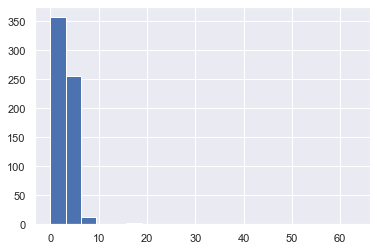

In [49]:
YouGovMRP["Green"].hist(bins=20);
YouGovMRP["Green"].sort_values()

0       0
382     0
380     0
379     0
378     0
       ..
374    19
241    21
203    23
12     24
11     25
Name: Brexit, Length: 632, dtype: int64

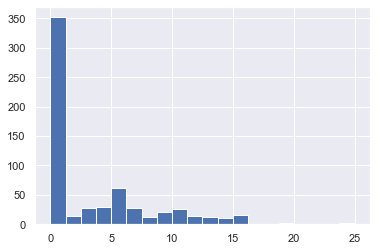

In [50]:
YouGovMRP["Brexit"].hist(bins=20);
YouGovMRP["Brexit"].sort_values()

In [51]:
YouGovMRP.loc[11]

Unnamed: 0                    12
i                             12
code                   E14000541
constituency    Barnsley Central
Con                           20
Lab                           44
LD                             6
Brexit                        25
Green                          4
SNP                            0
PC                             0
Other                          2
Name: 11, dtype: object

In [52]:
import geopandas as gpd
# set the filepath and load in a shapefile
fp = BES_small_data_files+"wpc.json"

map_df = gpd.read_file(fp)
# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

,PCON13CD,PCON13CDO,PCON13NM,geometry
0,E14000530,A01,Aldershot,POLYGON ((-0.804767102029057 51.24506643031432...
1,E14000531,A02,Aldridge-Brownhills,POLYGON ((-1.990861979367305 52.63665569511207...
2,E14000532,A03,Altrincham and Sale West,POLYGON ((-2.313999519326579 53.35740828054591...
3,E14000533,A04,Amber Valley,POLYGON ((-1.307988743544512 53.00385380561774...
4,E14000534,A05,Arundel and South Downs,(POLYGON ((-0.529146416920798 50.8655523965485...


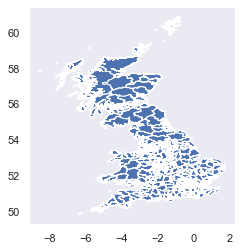

In [54]:
# now let's preview what our map looks like with no data in it
map_df.plot();

In [60]:
BES_census_data[BES_decomp.columns] = BES_decomp

In [61]:
# join the geodataframe with the cleaned up csv dataframe
merged = map_df.set_index("PCON13CD").join(BES_census_data.set_index("ONSConstID"))

merged.head()

,PCON13CDO,PCON13NM,geometry,pano,ConstituencyName,Country,Region,ConstituencyType,Winner17,Con17,...,c11Deprived1,c11Deprived2,c11Deprived3,c11Deprived4,MRP_winner,diversity,security,fecundity,diversity_flatter,security_flatter
PCON13CD,,,,,,,,,,,,,,,,,,,,,
E14000530,A01,Aldershot,POLYGON ((-0.804767102029057 51.24506643031432...,7,Aldershot,England,South East,Borough,Conservative,55.056180,...,32.837418,15.180993,3.624829,0.412987,Con,-2.066625,4.914989,4.088778,55,159
E14000531,A02,Aldridge-Brownhills,POLYGON ((-1.990861979367305 52.63665569511207...,8,Aldridge-Brownhills,England,West Midlands,Borough,Conservative,65.408227,...,33.062364,22.137760,4.520633,0.304065,Con,6.240992,-2.041164,2.169156,166,73
E14000532,A03,Altrincham and Sale West,POLYGON ((-2.313999519326579 53.35740828054591...,9,Altrincham and Sale West,England,North West,Borough,Conservative,51.019132,...,29.019254,13.370390,3.014597,0.180275,Con,1.199690,7.356067,2.469092,75,181
E14000533,A04,Amber Valley,POLYGON ((-1.307988743544512 53.00385380561774...,11,Amber Valley,England,East Midlands,County,Conservative,56.547554,...,31.407122,22.501256,5.186497,0.338365,Con,6.933946,-2.601251,0.329316,178,64
E14000534,A05,Arundel and South Downs,(POLYGON ((-0.529146416920798 50.8655523965485...,18,Arundel and South Downs,England,South East,County,Conservative,62.355616,...,32.722677,13.490611,2.154550,0.163698,Con,6.719999,8.014595,0.639030,174,185


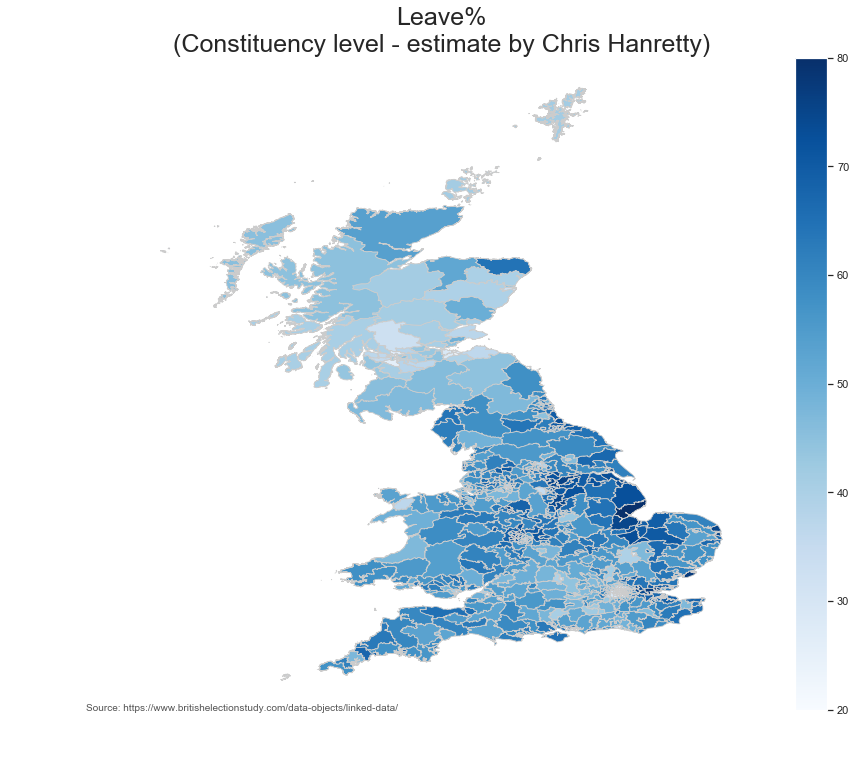

In [56]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'leaveHanretty'

# set the range for the choropleth
vmin, vmax = np.floor(BES_census_data["leaveHanretty"].min()/10)*10, np.ceil(BES_census_data["leaveHanretty"].max()/10)*10

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(16, 12))

# create map
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

# Now we can customise and add annotations

# remove the axis
ax.axis('off')

# add a title
ax.set_title('Leave%\n(Constituency level - estimate by Chris Hanretty)', \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# create an annotation for the  data source
ax.annotate('Source: https://www.britishelectionstudy.com/data-objects/linked-data/',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=10, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

Treatment = "Chloropleth"
output_subfolder = create_subdir(BES_output_folder,Treatment)
fname = output_subfolder +Treatment + ".png"
# this will save the figure as a high-res png. you can also save as svg
plt.savefig( fname, bbox_inches='tight', dpi=300 )


# fig.savefig('testmap.png', dpi=300)

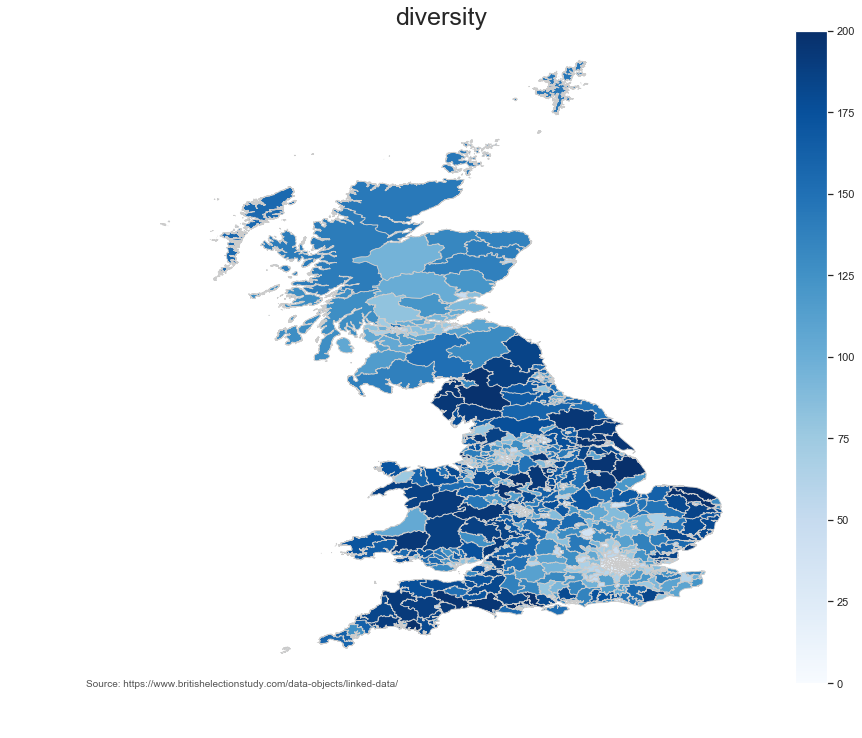

In [62]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'diversity_flatter'
title = 'diversity'

# set the range for the choropleth
vmin, vmax = np.floor(BES_census_data[variable].min()/10)*10, np.ceil(BES_census_data[variable].max()/10)*10

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(16, 12))

# create map
merged.plot(column=variable, cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8')

# Now we can customise and add annotations

# remove the axis
ax.axis('off')

# add a title
ax.set_title(title, \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# create an annotation for the  data source
ax.annotate('Source: https://www.britishelectionstudy.com/data-objects/linked-data/',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=10, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

Treatment = "Chloropleth"
output_subfolder = create_subdir(BES_output_folder,Treatment)
fname = output_subfolder +Treatment + ".png"
# this will save the figure as a high-res png. you can also save as svg
plt.savefig( fname, bbox_inches='tight', dpi=300 )


# fig.savefig('testmap.png', dpi=300)

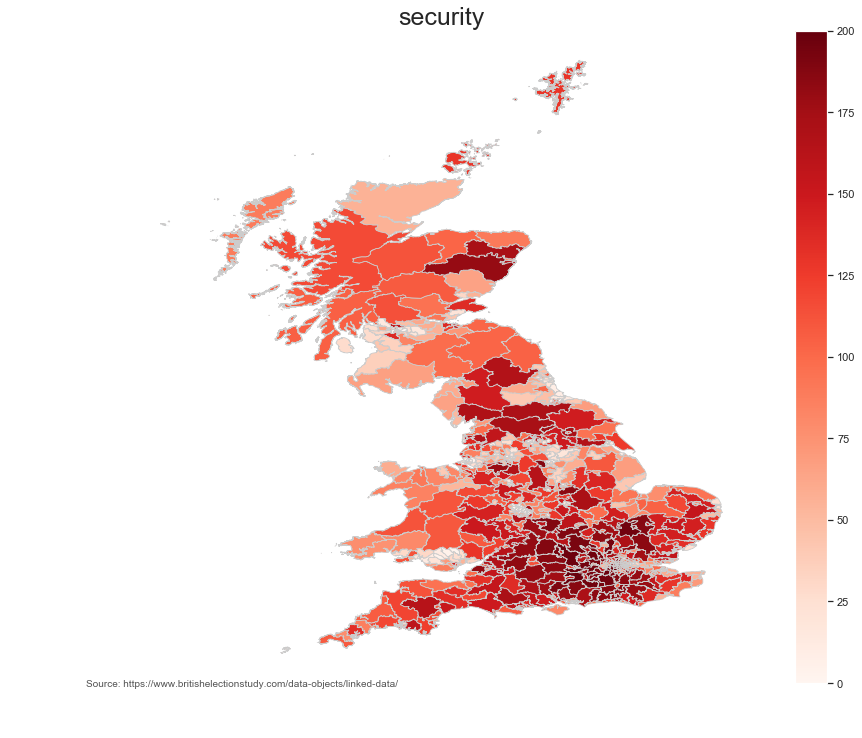

In [64]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'security_flatter'
title = 'security'
cmap = 'Reds'

# set the range for the choropleth
vmin, vmax = np.floor(BES_census_data[variable].min()/10)*10, np.ceil(BES_census_data[variable].max()/10)*10

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(16, 12))

# create map
merged.plot(column=variable, cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8')

# Now we can customise and add annotations

# remove the axis
ax.axis('off')

# add a title
ax.set_title(title, \
              fontdict={'fontsize': '25',
                        'fontweight' : '3'})

# create an annotation for the  data source
ax.annotate('Source: https://www.britishelectionstudy.com/data-objects/linked-data/',
           xy=(0.1, .08), xycoords='figure fraction',
           horizontalalignment='left', verticalalignment='top',
           fontsize=10, color='#555555')

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)

Treatment = "Chloropleth"
output_subfolder = create_subdir(BES_output_folder,Treatment)
fname = output_subfolder +Treatment + ".png"
# this will save the figure as a high-res png. you can also save as svg
plt.savefig( fname, bbox_inches='tight', dpi=300 )


# fig.savefig('testmap.png', dpi=300)

In [ ]:
##### BIRTH DATA
births = pd.read_csv(BES_small_data_files+"areaofusualresidencetables2016.csv", header=10, skip_blank_lines =True,skipfooter =14, engine='python')
births.drop("Unnamed: 20",axis=1,inplace=True)
births = births.dropna()

fertility_columns = ["Pop Total(1000s)","Pop Female(1000s)","Pop Female (15-44,1000s)",
 "Live Births Total","Live Births Male","Live Births Female",
 "Live Births Within Marriage/CP",
 "Live Births Outside Marriage/CP","Live Births Joint Reg Same Address",
 "Live Births Joint Reg Diff Address", "Live Births Sole Registrtions",
 "Crude Birth Rate(all live births per 1000)",
 "General Fertility Rate(all live births per 1000 women 15-44)",
 "Total Fertility Rate",
 "Percentage of live births outside marriage/CP",
 "Percentage of live births under 2.5kg",
 "Maternities Total",
 "Maternity Rate"]


births_by_areas = births.set_index("Unnamed: 1").loc[matched_areas].drop("Unnamed: 0",axis=1).copy()
births_by_areas = births_by_areas.apply(lambda x: pd.to_numeric(x.astype('str').str.replace(",","").replace(":","")))
births_by_areas.columns = fertility_columns


df = births_by_areas.reset_index().rename(columns={"Unnamed: 1":"ConstituencyName"})
BES_census_data = BES_census_data.merge(df, on = ["ConstituencyName"], how='left')

In [ ]:
BES_cens_base.merge(births_by_areas)
intersection(births["Unnamed: 0"].values , BES_census_data["ONSConstID"].values)
matched_areas =  intersection(births["Unnamed: 1"].values , BES_census_data["ConstituencyName"].values)
matched_areas